Saved figure to: D:\DCM_manuscript_figure\baseline_segment1T.svg


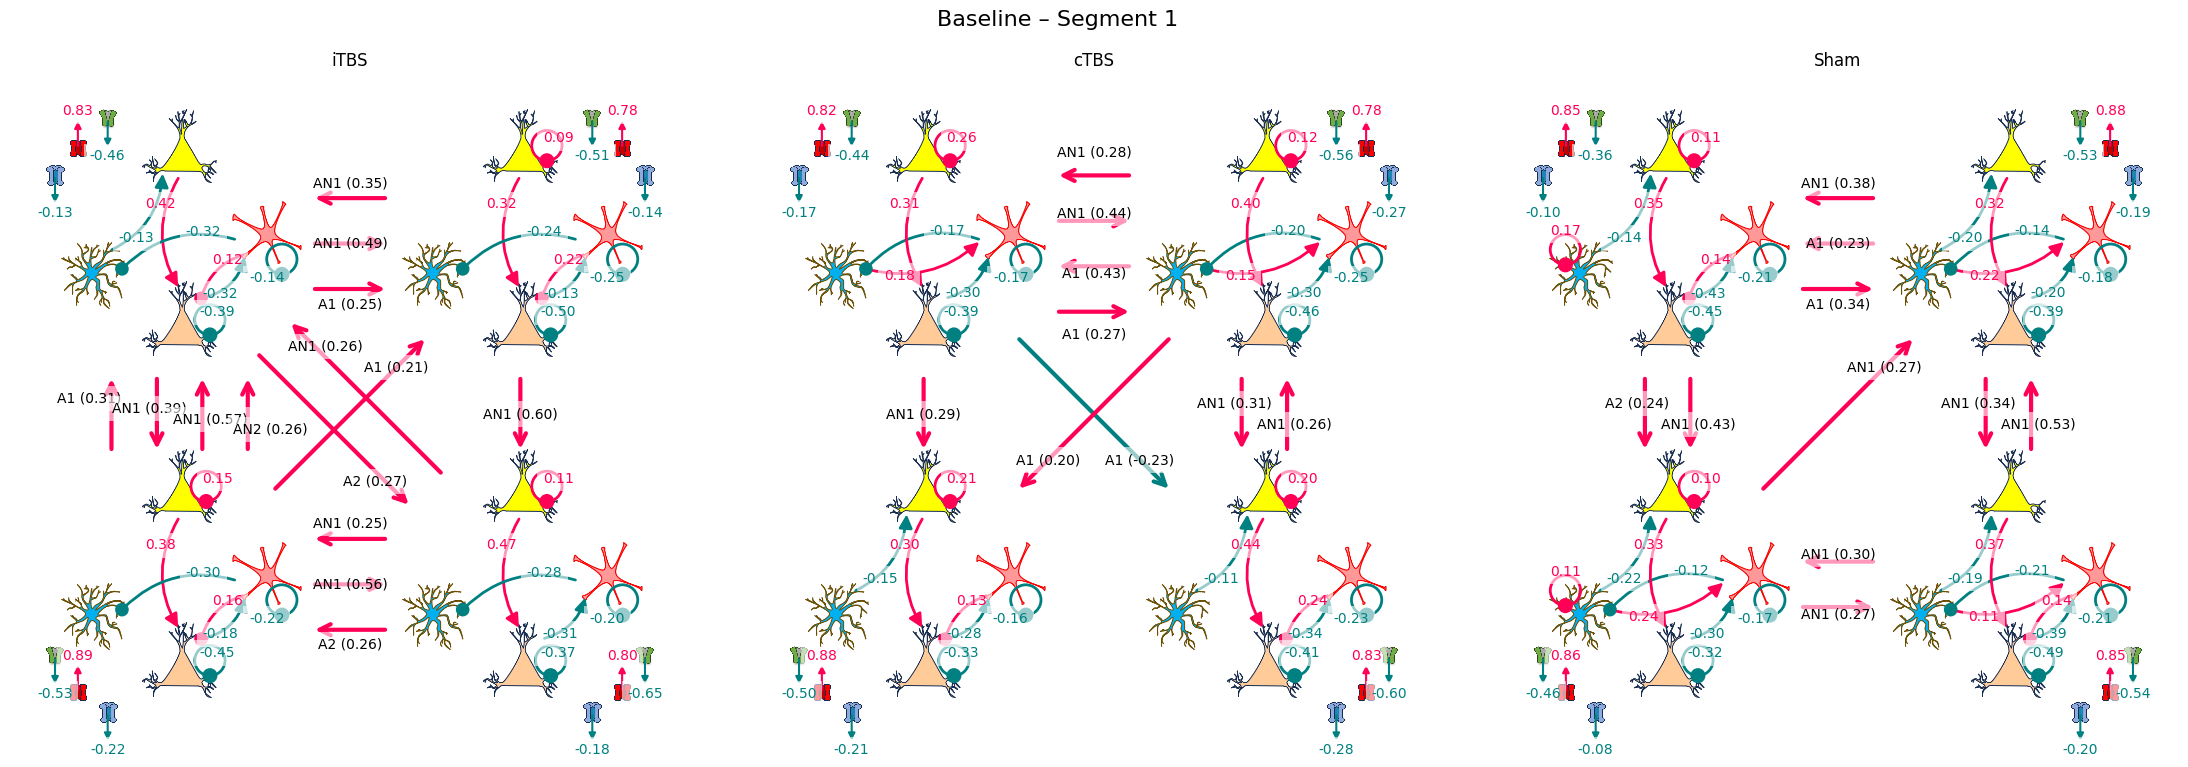

Saved figure to: D:\DCM_manuscript_figure\sustained_segment1T.svg


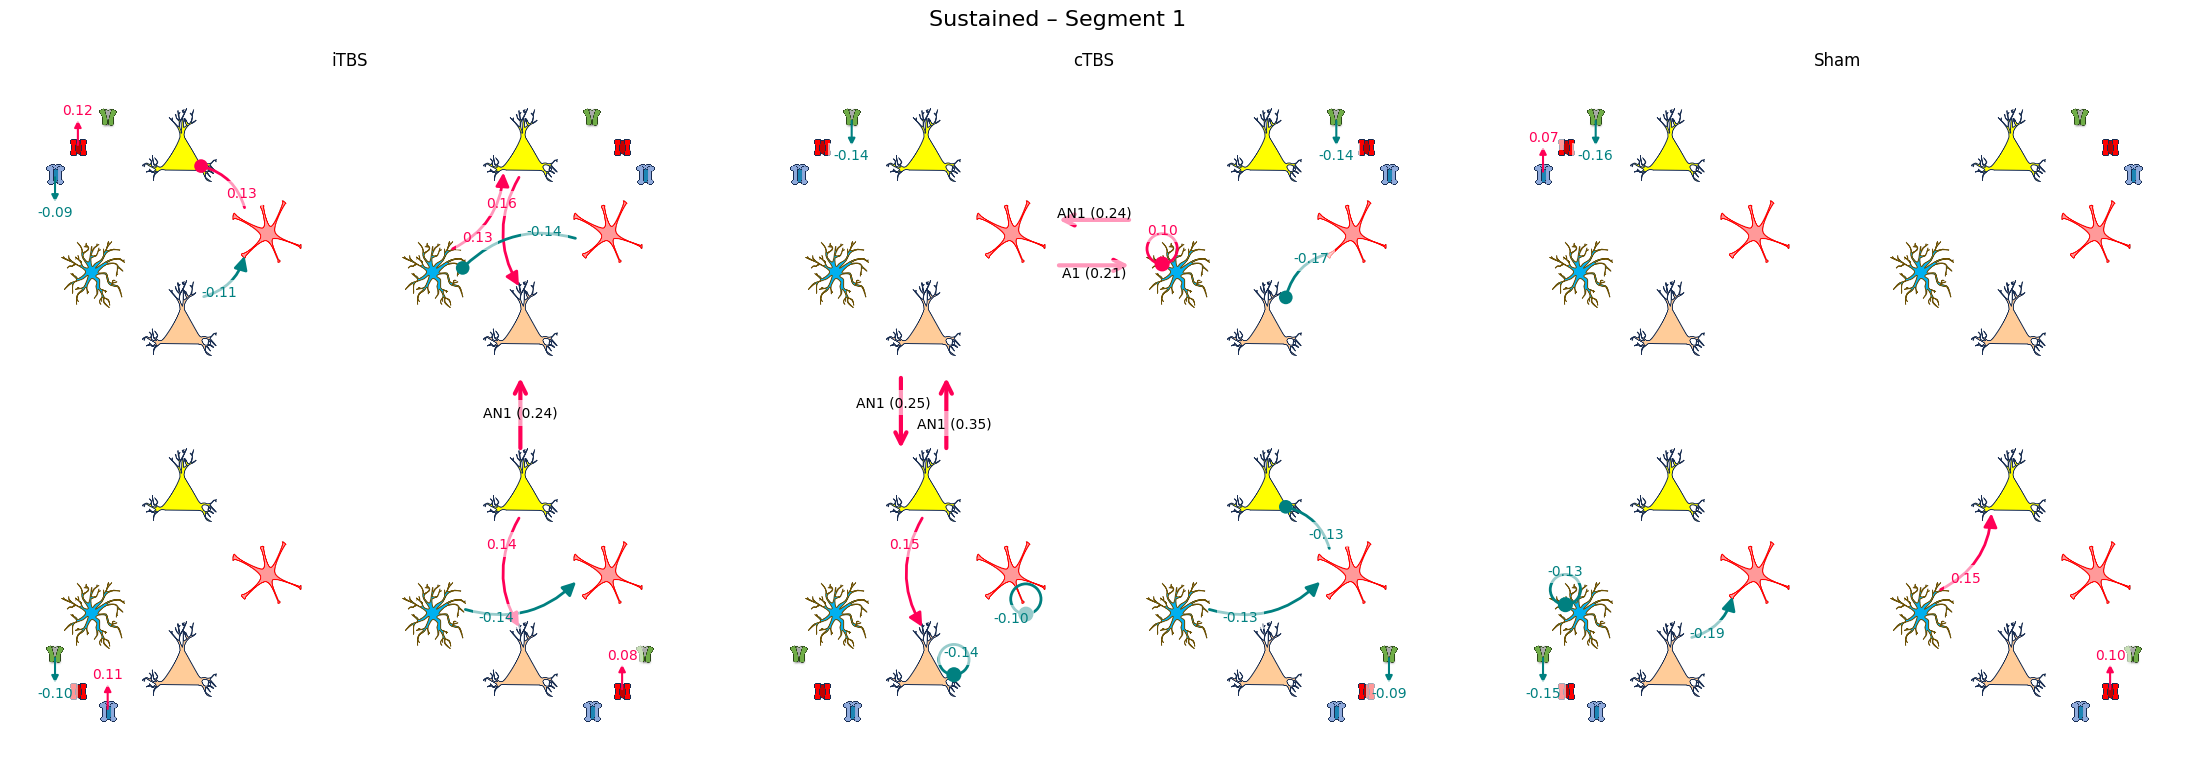

Saved figure to: D:\DCM_manuscript_figure\transient_segment1T.svg


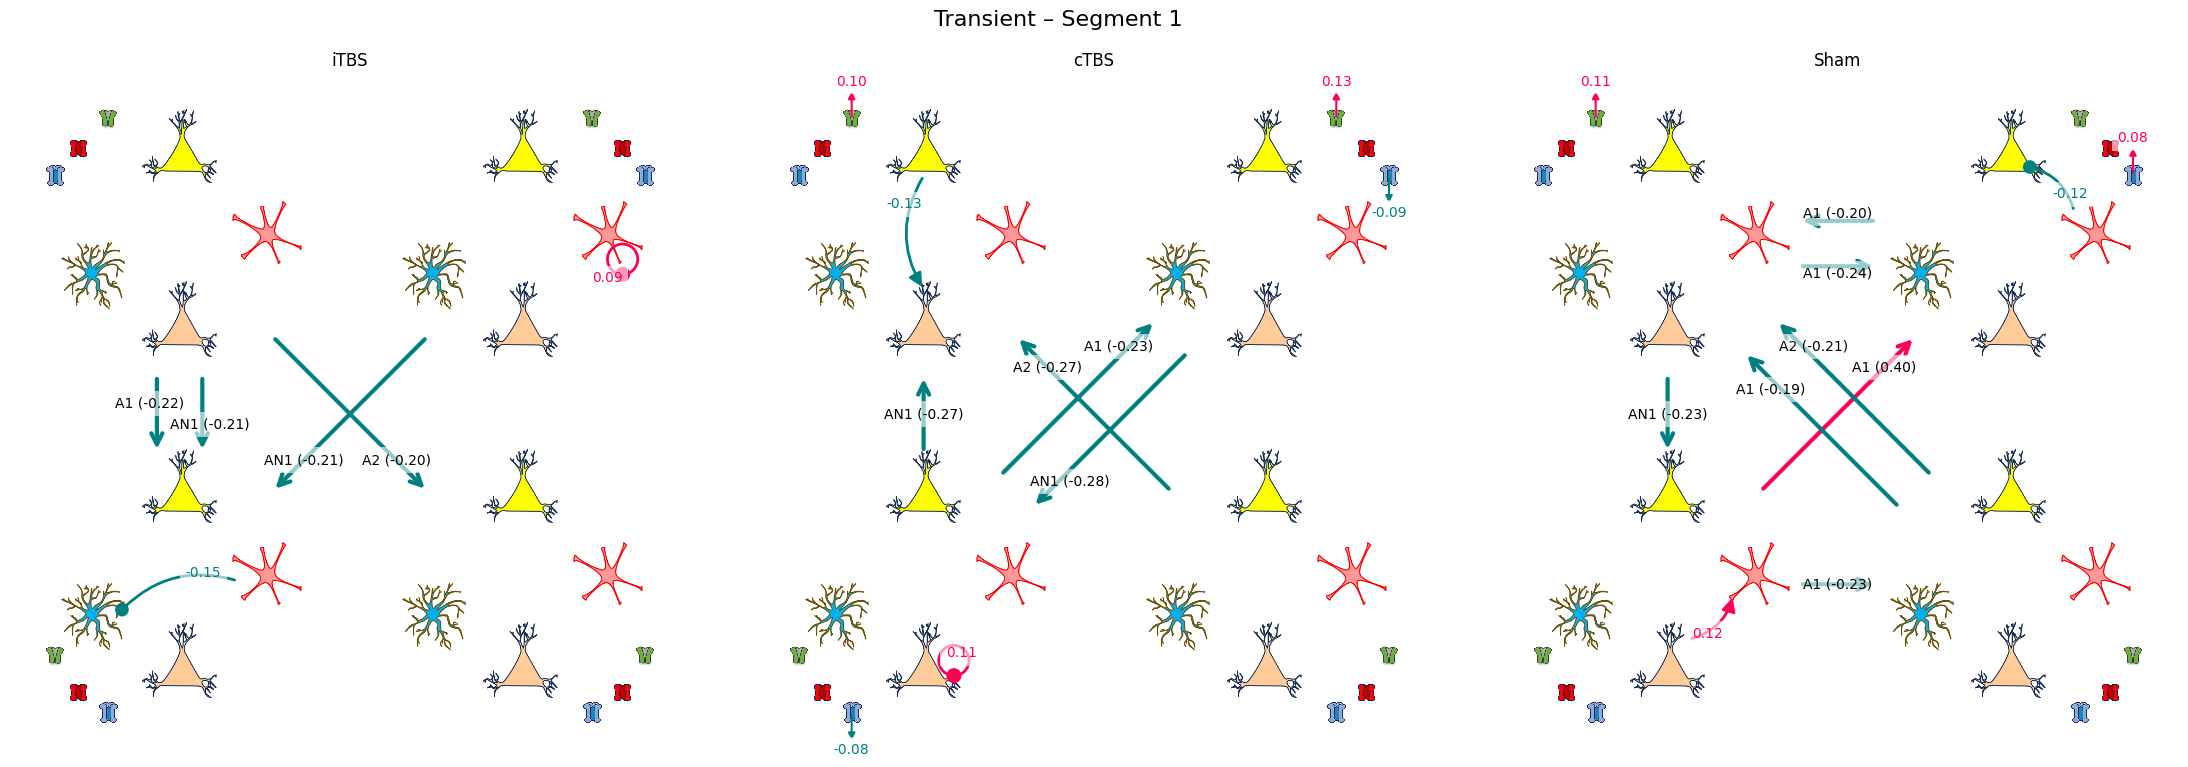

In [20]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.sparse import issparse
import networkx as nx
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox  # used for label/icon bbox computations

# -----------------------------------------------------------------------------
# Export helpers (additional raster formats and color spaces)
# -----------------------------------------------------------------------------
import io
from PIL import Image
from collections import defaultdict

# -----------------------------------------------------------------------------
# Arrow polarity colors
# -----------------------------------------------------------------------------
POS_COLOR = '#FF0056'   # positive effect
NEG_COLOR = '#008080'   # negative effect

def fmt_trunc_str(x, ndigits=2):
    # Truncate numeric text to a fixed number of decimals (no rounding).
    s = str(x)
    if "." in s:
        whole, frac = s.split(".", 1)
        frac = (frac + "0"*ndigits)[:ndigits]
        return f"{whole}.{frac}"
    else:
        return f"{s}.{'0'*ndigits}"

# -----------------------------------------------------------------------------
# Layout/style knobs (tuned to match prior figures)
# -----------------------------------------------------------------------------
ICON_ZOOM               = 0.35
SHAPE_ICON_ZOOM         = 0.1
SHAPE_ARROW_LENGTH      = 0.8
GRID_SPACING            = 9
REGION_RADIUS           = 2.5
BASE_OFFSET             = 1.2     # lateral lane offset for multi-edges
LABEL_PADDING           = 0.4     # perpendicular nudge for edge labels
PARALLEL_PADDING        = 0.3     # parallel nudge for non-vertical edges
VERTICAL_LABEL_PAD      = 0.9     # stronger parallel nudge for near-vertical edges
SCALE_INTRINSIC         = 2.3
INTRINSIC_ARROW_PADDING = 0.8
CIRCLE_HEAD_RADIUS      = 0.18
CIRCLE_POINTER_SIZE     = CIRCLE_HEAD_RADIUS * 2
FIG_WIDTH_PER           = 8
FIG_HEIGHT              = 8

# --- Font size knobs ----------------------------------------------------------
FONT_SIZE_EXTRINSIC = 10   # A/AN edge labels between regions
FONT_SIZE_INTRINSIC = 10    # H(...) labels inside regions (incl. self-loops)
FONT_SIZE_ION       = 10    # Ion-channel value labels by the icons

# Additional shortening applied to extrinsic arrows near node edges (data units)
EXTRINSIC_TRIM          = 1

# Output filename suffix for exported figures
FILENAME_SUFFIX         = "T"

# Treat an edge as "vertical" when |ux| < threshold (for label strategy)
VERTICAL_THRESH         = 0.10

# Unified label background style
LABEL_BG_COLOR   = 'white'
LABEL_BG_ALPHA   = 0.6   # requested transparency
LABEL_EDGE_COLOR = 'none'

# On the two main crossing diagonals, move labels away from the crossing, toward target.
# Final along-edge parameter ≈ 0.5 + DIAG_LABEL_SHIFT (clamped to [0.05, 0.95]).
DIAG_LABEL_SHIFT = 0.3

# Per-channel vertical micro-nudges for icon placement
ION_CHANNEL_Y_OFFSETS = {
    1: -0.10,
    2: -0.18,
    3:  0.00,
}

# Ring placement for ion-channel icons around each region
ICON_RING_OFFSET   = 1.3
ICON_ANG_OFFSETS   = {1: 0.0, 2: 0.0, 3: 0.0}   # per-channel angle tweak (deg)
ICON_RADIAL_OFFS   = {1: 0.0, 2: 0.0, 3: 0.0}   # per-channel radial tweak

# Self-loop placement and label offsets (per intrinsic node id)
SELF_LOOP_OFFSETS = {
    1: (-0.4, 0.7),
    2: (0.7,  0.0),
    3: (0.4,  -0.7),
    4: (0.8, 0.0),
}
SELF_LOOP_LABEL_OFFSETS = {
    1: (-0.4, 1.2),
    2: (1.0,  0.2),
    3: (0.0,  -1.2),
    4: (1.0,  0.2),
}

# Covariate → display title mapping (keys normalized downstream)
RAW_TITLE_MAP = {
    'covariate1': 'baseline',
    'covariate2': 'sustained',
    'covariate3': 'transient'
}

# -----------------------------------------------------------------------------
# Region grid layout and image paths (absolute paths expected)
# -----------------------------------------------------------------------------
region_positions = {
    1: (0, GRID_SPACING),
    2: (GRID_SPACING, GRID_SPACING),
    3: (0, 0),
    4: (GRID_SPACING, 0)
}
intrinsic_base_positions = {
    1: (-1, 0.5),
    2: (0, 2.0),
    3: (1, 1.0),
    4: (0, 0)
}
cell_nodes = {1: "SS", 2: "SP", 3: "II", 4: "DP"}
node_images = {
    1: r"D:\DCM_manuscript_figure\pics\Picture6.png",
    2: r"D:\DCM_manuscript_figure\pics\Picture5.png",
    3: r"D:\DCM_manuscript_figure\pics\Picture7.png",
    4: r"D:\DCM_manuscript_figure\pics\Picture8.png"
}
shape_images = {
    1: r"D:\DCM_manuscript_figure\pics\Picture10.png",
    2: r"D:\DCM_manuscript_figure\pics\Picture20.png",
    3: r"D:\DCM_manuscript_figure\pics\Picture30.png"
}

# -----------------------------------------------------------------------------
# Helper: circular self-loop with a round head
# -----------------------------------------------------------------------------
def draw_self_loop_with_circle(ax, position, loop_radius=0.4, color=NEG_COLOR,
                               lw=2, offset=(0, 0), arrow_angle_deg=270,
                               pointer_size=CIRCLE_POINTER_SIZE):
    cx, cy = position[0] + offset[0], position[1] + offset[1]
    loop = patches.Circle((cx, cy), loop_radius,
                          edgecolor=color, facecolor='none',
                          lw=lw, zorder=12)
    ax.add_patch(loop)
    angle = np.deg2rad(arrow_angle_deg)
    bx = cx + loop_radius * np.cos(angle)
    by = cy + loop_radius * np.sin(angle)
    head = patches.Circle((bx, by), pointer_size / 2,
                          edgecolor=color, facecolor=color,
                          zorder=13)
    ax.add_patch(head)
    return loop, head

# -----------------------------------------------------------------------------
# Overlap utilities (bbox extraction + axis-based nudge for labels)
# -----------------------------------------------------------------------------
class TransformedBbox(Bbox):
    def __new__(cls, bbox, transform):
        pts = transform.transform(bbox.get_points())
        return Bbox.from_extents(pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1])

def _get_artist_bbox_in_data(ax, artist):
    """Artist bbox in data coords; falls back to a minimal box at its xy/position."""
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    try:
        bb_disp = artist.get_window_extent(renderer=renderer)
        bb_data = TransformedBbox(bb_disp, ax.transData.inverted())
        if not np.isfinite([bb_data.x0, bb_data.y0, bb_data.x1, bb_data.y1]).all():
            raise ValueError
        return bb_data
    except Exception:
        try:
            x, y = artist.xy
        except Exception:
            try:
                x, y = artist.get_position()
            except Exception:
                x, y = (0.0, 0.0)
        eps = 1e-6
        return Bbox.from_extents(x - eps, y - eps, x + eps, y + eps)

def _get_text_bbox_in_data(ax, text):
    """Text bbox in data coords with a robust fallback for invalid extents."""
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bb_disp = text.get_window_extent(renderer=renderer)
    bb_data = TransformedBbox(bb_disp, ax.transData.inverted())
    if not np.isfinite([bb_data.x0, bb_data.y0, bb_data.x1, bb_data.y1]).all():
        x, y = text.get_position()
        eps = 1e-6
        bb_data = Bbox.from_extents(x - eps, y - eps, x + eps, y + eps)
    return bb_data

def _overlap_amount(a: Bbox, b: Bbox, pad=0.0):
    """Return overlap (dx, dy) between two bboxes with optional padding."""
    ax0, ay0, ax1, ay1 = a.x0 - pad, a.y0 - pad, a.x1 + pad, a.y1 + pad
    bx0, by0, bx1, by1 = b.x0 - pad, b.y0 - pad, b.x1 + pad, b.y1 + pad
    overlap_x = min(ax1, bx1) - max(ax0, bx0)
    overlap_y = min(ay1, by1) - max(ay0, by0)
    if overlap_x <= 0 or overlap_y <= 0:
        return 0.0, 0.0
    return overlap_x, overlap_y

def resolve_text_overlaps_axis_fixed(ax, texts, fixed_texts=None, pad=0.15, step=0.08, max_iter=300):
    """
    Iteratively nudge labels to remove overlaps.
    - 'texts'       : movable labels
    - 'fixed_texts' : obstacles (not moved)
    The later label in each conflict pair is moved to reduce cascades.
    """
    if not texts:
        return
    fixed_texts = fixed_texts or []
    for _ in range(max_iter):
        moved = False
        bboxes_mov = [_get_text_bbox_in_data(ax, t) for t in texts]
        bboxes_fix = [_get_text_bbox_in_data(ax, t) for t in fixed_texts] if fixed_texts else []
        for j in range(len(texts)):
            bj = bboxes_mov[j]
            # Move away from fixed obstacles
            for fb in bboxes_fix:
                dx_need, dy_need = _overlap_amount(bj, fb, pad=pad)
                if dx_need > 0 and dy_need > 0:
                    bxc = 0.5 * (bj.x0 + bj.x1); byc = 0.5 * (bj.y0 + bj.y1)
                    axc = 0.5 * (fb.x0 + fb.x1); ayc = 0.5 * (fb.y0 + fb.y1)
                    if dx_need <= dy_need:
                        direction = 1.0 if bxc >= axc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj + direction * (dx_need + step), yj))
                    else:
                        direction = 1.0 if byc >= ayc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj, yj + direction * (dy_need + step)))
                    moved = True
            # Move away from earlier movable labels (i < j)
            for i in range(j):
                bi = bboxes_mov[i]
                dx_need, dy_need = _overlap_amount(bj, bi, pad=pad)
                if dx_need > 0 and dy_need > 0:
                    axc = 0.5 * (bi.x0 + bi.x1); ayc = 0.5 * (bi.y0 + bi.y1)
                    bxc = 0.5 * (bj.x0 + bj.x1); byc = 0.5 * (bj.y0 + bj.y1)
                    if dx_need <= dy_need:
                        direction = 1.0 if bxc >= axc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj + direction * (dx_need + step), yj))
                    else:
                        direction = 1.0 if byc >= ayc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj, yj + direction * (dy_need + step)))
                    moved = True
        if not moved:
            break

# -----------------------------------------------------------------------------
# Ion-channel helpers (equal-angle placement + optional overlap push-out)
# -----------------------------------------------------------------------------
def compute_channel_xy(cx, cy, angle_deg, base_radius, y_nudge=0.0):
    x = cx + base_radius * np.cos(np.deg2rad(angle_deg))
    y = cy + base_radius * np.sin(np.deg2rad(angle_deg)) + y_nudge
    return x, y

def adjust_channel_neuron_overlaps(ax, channel_records_by_area, neuron_artists_by_area,
                                   pad=0.01, radial_step=0.25, max_iter=25):
    """
    For each area, if a channel icon overlaps any neuron icon, push the channel
    outward along its current angle by 'radial_step' until no overlap or max_iter.
    """
    fig = ax.figure
    for area, ch_list in channel_records_by_area.items():
        neur_list = neuron_artists_by_area.get(area, [])
        if not neur_list or not ch_list:
            continue
        for rec in ch_list:
            ang  = rec['angle_deg']
            r    = rec['radius']
            cx, cy = rec['center']
            yn    = rec['y_nudge']
            artist = rec['artist']
            for _ in range(max_iter):
                fig.canvas.draw()
                ch_bb = _get_artist_bbox_in_data(ax, artist)
                overlap_found = False
                for neur in neur_list:
                    neur_bb = _get_artist_bbox_in_data(ax, neur)
                    dx_need, dy_need = _overlap_amount(ch_bb, neur_bb, pad=pad)
                    if dx_need > 0 and dy_need > 0:
                        overlap_found = True
                        break
                if not overlap_found:
                    break
                r += radial_step
                x, y = compute_channel_xy(cx, cy, ang, r, yn)
                try:
                    artist.xy = (x, y)  # AnnotationBbox
                except Exception:
                    artist.set_xy((x, y))  # fallback
                rec['radius'] = r

# -----------------------------------------------------------------------------
# .mat loader → segments with extrinsic / intrinsic / ion-channel data
# -----------------------------------------------------------------------------
def process_file(mat_file_path):
    """
    Loads Results.PEB_thresholded and returns a list of segments (dicts).
      segment = {
        'cov_extrinsic':    {cov: [(src, tgt, label, Ep), ...], ...},
        'covariate_groups': {cov: [{'label': 'H(...)', 'Ep': val}, ...], ...},
        'cov_shape':        {cov: [(area, shape_idx, Ep), ...], ...},
        'cov_keys_all':     [all covariate keys seen in this segment],
        'segment':          1-based index
      }
    Works with:
      (A) old format: struct array [N x 1] with scalar Ep, string Pnames
      (B) new format: scalar struct with Ep [nSeg*nNames] (can be dense/sparse),
                      Pnames [nNames] (cellstr/char/object)
    """
    import re
    import numpy as np
    import scipy.io as sio
    from scipy.sparse import issparse

    pat_ex    = re.compile(r'(?i)\b(A|AN)\{(\d+)\}\(\s*(\d+)\s*,\s*(\d+)\s*\)')
    pat_shape = re.compile(r'(?i)^covariate\s+(\d+)\s*:\s*T\(\s*(\d+)\s*,\s*(\d+)(?:\s*,\s*\d+)?\s*\)$')

    def to_float(v):
        # robust scalar extractor: handles sparse, numpy scalars, 0-d arrays, python scalars
        try:
            if issparse(v):
                arr = v.toarray()
                return float(np.asarray(arr).squeeze())
        except Exception:
            pass
        try:
            return float(np.asarray(v).squeeze())
        except Exception:
            # last resort
            return float(v)

    def normalize_pnames(pnames_field):
        # unwrap nested 1x1 object arrays and cellstrs
        x = pnames_field
        while isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
            x = x.item()
        if isinstance(x, (list, tuple)):
            return [str(s).strip() for s in x]
        if isinstance(x, np.ndarray):
            if x.dtype == object:
                return [str(s).strip() for s in x.ravel()]
            # char/unicode array fallback
            return [str(s).strip() for s in x.ravel()]
        return [str(x).strip()]

    def flatten_numeric(vec_like):
        # vec_like can be dense ndarray, sparse matrix/array, or object array of scalars/sparses
        if issparse(vec_like):
            return np.asarray(vec_like.toarray(), dtype=float).ravel()
        try:
            return np.asarray(vec_like, dtype=float).ravel()
        except Exception:
            return np.array([to_float(x) for x in np.ravel(vec_like)], dtype=float)

    mat = sio.loadmat(mat_file_path, squeeze_me=True, struct_as_record=False)
    if 'Results' not in mat:
        raise KeyError(f"'Results' not found in {mat_file_path}")
    res = mat['Results']
    if not hasattr(res, 'PEB_thresholded'):
        raise KeyError(f"'Results.PEB_thresholded' not found in {mat_file_path}")
    peb = res.PEB_thresholded

    segments = []

    # ----- CASE B: scalar struct with vector fields -----
    if hasattr(peb, 'Ep') and hasattr(peb, 'Pnames'):
        Ep_vec = flatten_numeric(getattr(peb, 'Ep'))
        Pnames_block = normalize_pnames(getattr(peb, 'Pnames'))
        Np = len(Pnames_block)
        if Np == 0:
            raise ValueError("Pnames block is empty in PEB_thresholded.")

        nseg = (len(Ep_vec) // Np) if (len(Ep_vec) % Np == 0 and len(Ep_vec) >= Np) else 1

        for s in range(nseg):
            Ep_s = Ep_vec[s * Np:(s + 1) * Np] if nseg > 1 else Ep_vec

            cov_ex, cov_int, cov_shape = {}, {}, {}
            for i, pn in enumerate(Pnames_block):
                val = float(Ep_s[i])

                # Ion-channel T(...): keep even when val==0 to place icon
                m_sh = pat_shape.search(pn)
                if m_sh:
                    cov_idx, area, shape_idx = map(int, m_sh.groups())
                    key = f"Covariate {cov_idx}"
                    cov_shape.setdefault(key, []).append((area, shape_idx, val))

                # skip zeros for extrinsic/intrinsic only (clutter control)
                if val == 0:
                    continue

                # split "Covariate X: <connection label>"
                if ':' in pn:
                    parts = re.split(r'\s*:\s*', pn, maxsplit=1)
                    cov, conn = (parts[0].strip(), parts[1].strip()) if len(parts) == 2 else (pn, '')
                else:
                    cov, conn = pn, ''

                # Extrinsic A/AN{ins}(tgt,src)
                m_ex = pat_ex.search(conn)
                if m_ex:
                    typ, ins, tgt, src = m_ex.groups()
                    src_i, tgt_i = int(src), int(tgt)
                    cov_ex.setdefault(cov, []).append((src_i, tgt_i, f"{typ}{ins}", val))

                # Intrinsic H(...)
                if re.match(r'(?i)^covariate\s+\d+\b', cov) and conn.startswith('H'):
                    cov_int.setdefault(cov, []).append({"label": conn, "Ep": val})

            # collect all cov keys seen in this segment (for ordered_covs)
            cov_keys = set(cov_ex.keys()) | set(cov_int.keys()) | set(cov_shape.keys())
            cov_keys_all = sorted(
                cov_keys,
                key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 10**9
            )

            segments.append({
                'cov_extrinsic':    cov_ex,
                'covariate_groups': cov_int,
                'cov_shape':        cov_shape,
                'cov_keys_all':     cov_keys_all,
                'segment':          s + 1
            })
        return segments

    # ----- CASE A: struct array (old format) -----
    if isinstance(peb, np.ndarray):
        Ep_list, Pnames_list = [], []
        for elem in np.ravel(peb):
            Ep_list.append(to_float(getattr(elem, 'Ep')))
            Pnames_list.append(str(getattr(elem, 'Pnames')).strip())

        Ep = np.asarray(Ep_list, dtype=float)
        Pnames = list(Pnames_list)

        Np = len(Pnames)
        if Np == 0:
            raise ValueError("No parameter names found in PEB_thresholded.")
        nseg = len(Ep) // Np if len(Ep) % Np == 0 else 1

        for s in range(nseg):
            Ep_s = Ep[s * Np:(s + 1) * Np] if nseg > 1 else Ep

            cov_ex, cov_int, cov_shape = {}, {}, {}
            for i, pn in enumerate(Pnames):
                val = float(Ep_s[i])

                m_sh = pat_shape.search(pn)
                if m_sh:
                    cov_idx, area, shape_idx = map(int, m_sh.groups())
                    key = f"Covariate {cov_idx}"
                    cov_shape.setdefault(key, []).append((area, shape_idx, val))

                if val == 0:
                    continue

                if ':' in pn:
                    parts = re.split(r'\s*:\s*', pn, maxsplit=1)
                    cov, conn = (parts[0].strip(), parts[1].strip()) if len(parts) == 2 else (pn, '')
                else:
                    cov, conn = pn, ''

                m_ex = pat_ex.search(conn)
                if m_ex:
                    typ, ins, tgt, src = m_ex.groups()
                    src_i, tgt_i = int(src), int(tgt)
                    cov_ex.setdefault(cov, []).append((src_i, tgt_i, f"{typ}{ins}", val))

                if re.match(r'(?i)^covariate\s+\d+\b', cov) and conn.startswith('H'):
                    cov_int.setdefault(cov, []).append({"label": conn, "Ep": val})

            cov_keys = set(cov_ex.keys()) | set(cov_int.keys()) | set(cov_shape.keys())
            cov_keys_all = sorted(
                cov_keys,
                key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 10**9
            )

            segments.append({
                'cov_extrinsic':    cov_ex,
                'covariate_groups': cov_int,
                'cov_shape':        cov_shape,
                'cov_keys_all':     cov_keys_all,
                'segment':          s + 1
            })
        return segments

    raise TypeError("Unrecognized PEB_thresholded format.")

# -----------------------------------------------------------------------------
# Plot a single covariate on a single Axes
# -----------------------------------------------------------------------------
def plot_connectivity_for_covariate(ax, cov, data):
    ax.set_aspect('equal', 'box')
    ax.axis('off')

    # Region circles (hidden stroke; used for spacing)
    for pos in region_positions.values():
        ax.add_patch(patches.Circle(pos, REGION_RADIUS,
                                    facecolor='none', edgecolor='black',
                                    lw=0, zorder=1))

    # -------------------------------------------------------------------------
    # Ion-channel icons & arrows (equal angular spacing on a ring)
    # -------------------------------------------------------------------------
    cov_shapes = data.get('cov_shape', {}).get(cov, [])
    shapes_by_area = {}
    for area, shape_idx, ep_val in cov_shapes:
        shapes_by_area.setdefault(area, []).append((shape_idx, ep_val))

    # Keep icon artists per area so we can resolve overlaps against neuron icons
    channel_artists_by_area = defaultdict(list)

    base_angles = {1:135, 2:45, 3:225, 4:315}
    spread_deg  = 30

    for area, items in shapes_by_area.items():
        items_sorted = sorted(items, key=lambda x: x[0])
        n = len(items_sorted)
        cx, cy = region_positions[area]

        # Equal angular spacing across a symmetric arc
        if n > 1:
            angs = np.linspace(base_angles[area] - spread_deg/2,
                               base_angles[area] + spread_deg/2, n)
        else:
            angs = np.array([base_angles[area]])

        # Optional reversal to keep visual orientation consistent for areas 1 & 3
        if area in (1, 3):
            angs = angs[::-1]

        for (shape_idx, ep_val), ang in zip(items_sorted, angs):
            ang = ang + ICON_ANG_OFFSETS.get(shape_idx, 0.0)
            r   = REGION_RADIUS + ICON_RING_OFFSET + ICON_RADIAL_OFFS.get(shape_idx, 0.0)

            # Final ring position (+ optional per-channel y-nudge)
            x0, y0 = compute_channel_xy(cx, cy, ang, r, ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0))

            try:
                img_arr = plt.imread(shape_images[shape_idx])
                img_box = OffsetImage(img_arr, zoom=SHAPE_ICON_ZOOM)
                ab = AnnotationBbox(img_box, (x0, y0), frameon=False, zorder=5)
                ax.add_artist(ab)
                channel_artists_by_area[area].append({
                    'artist': ab,
                    'angle_deg': ang,
                    'radius': r,
                    'center': (cx, cy),
                    'y_nudge': ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0),
                })
            except FileNotFoundError:
                sc = ax.scatter(x0, y0, s=100, color='gray', zorder=5)
                channel_artists_by_area[area].append({
                    'artist': sc,
                    'angle_deg': ang,
                    'radius': r,
                    'center': (cx, cy),
                    'y_nudge': ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0),
                })

            # Up/down arrow & value label
            if ep_val != 0:
                col = POS_COLOR if ep_val > 0 else NEG_COLOR
                dy_arrow = SHAPE_ARROW_LENGTH if ep_val > 0 else -SHAPE_ARROW_LENGTH
                ax.annotate('', xy=(x0, y0+dy_arrow), xytext=(x0, y0),
                            arrowprops=dict(arrowstyle='-|>', color=col, lw=1.5),
                            zorder=6)
                ax.text(x0, y0+dy_arrow, fmt_trunc_str(ep_val, 2),
                        color=col, fontsize=FONT_SIZE_ION,
                        ha='center',
                        va='bottom' if ep_val > 0 else 'top',
                        bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                        zorder=6)

    # -------------------------------------------------------------------------
    # Extrinsic edges (between regions) with lane-aware labels
    # -------------------------------------------------------------------------
    cov_ex = data['cov_extrinsic'].get(cov, [])
    # Group by undirected pair so both directions can be laid out together
    grouped_ex = {}
    for src, tgt, lab, ep in cov_ex:
        grouped_ex.setdefault(tuple(sorted((src, tgt))), []).append((src, tgt, lab, ep))

    nonvertical_texts = []
    vertical_texts    = []  # treated as obstacles in the overlap solver

    DIAGONAL_PAIRS = {(1, 4), (2, 3)}

    for undirected_pair, conns in grouped_ex.items():
        # Canonical geometry for the pair
        src0, tgt0, _, _ = conns[0]
        P_src0, P_tgt0 = np.array(region_positions[src0]), np.array(region_positions[tgt0])
        vec_pair = P_tgt0 - P_src0
        L_pair = np.linalg.norm(vec_pair)
        if L_pair == 0:
            continue
        unit_pair = vec_pair / L_pair
        is_vertical_pair = abs(unit_pair[0]) < VERTICAL_THRESH

        # Canonical axis: top → bottom
        u_pair = -unit_pair if unit_pair[1] > 0 else unit_pair

        # Trim central segment for label positions (keeps labels off node rims)
        trim = REGION_RADIUS + EXTRINSIC_TRIM
        pair_mid = (P_src0 + P_tgt0) / 2.0
        half_len = (L_pair - 2 * trim) / 2.0
        if half_len < 0:
            half_len = 0
        start_base = pair_mid - u_pair * half_len
        end_base   = pair_mid + u_pair * half_len

        seg_len_pair = float(np.linalg.norm(end_base - start_base))
        t_margin = 0.45
        t_min = t_margin
        t_max = max(0.0, seg_len_pair - t_margin)

        # If the pair is vertical, assign shared along-edge label slots to all lanes
        if is_vertical_pair:
            k = len(conns)
            if k > 0 and t_max > t_min:
                segment = (t_max - t_min) / k
                t_positions = [t_min + (i + 0.5) * segment for i in range(k)]
            else:
                t_positions = [0.5 * (t_min + t_max)] * k

        # Draw each arrow and place its label
        for idx, (src, tgt, lab, ep) in enumerate(conns):
            base_idx = idx - (len(conns)-1)/2
            sign     = 1 if src < tgt else -1
            off_fac  = base_idx * sign

            # Arrow geometry
            P_src, P_tgt = np.array(region_positions[src]), np.array(region_positions[tgt])
            vec = P_tgt - P_src
            L = np.linalg.norm(vec)
            unit = vec / L if L else np.zeros(2)
            perp = np.array([-unit[1], unit[0]])
            start = P_src + perp*BASE_OFFSET*off_fac + unit*trim
            end   = P_tgt + perp*BASE_OFFSET*off_fac - unit*trim

            color = POS_COLOR if ep > 0 else NEG_COLOR
            ax.annotate('', xy=tuple(end), xytext=tuple(start),
                        arrowprops=dict(arrowstyle='->', lw=3,
                                        color=color, mutation_scale=20),
                        zorder=3)

            # Label placement
            if is_vertical_pair:
                # Shared along-edge position; lateral offset follows this arrow's lane
                t_i = t_positions[idx]
                base_point = start_base + u_pair * t_i
                lane_shift_scalar = (BASE_OFFSET + LABEL_PADDING) * off_fac
                lbl_pos = base_point + perp * lane_shift_scalar

                txt = ax.text(lbl_pos[0], lbl_pos[1],
                              f"{lab} ({fmt_trunc_str(ep, 2)})",
                              color='black', fontsize=FONT_SIZE_EXTRINSIC, ha='center', va='center',
                              zorder=4,
                              bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR))
                vertical_texts.append(txt)
            else:
                # Midpoint + small along/perp nudges; push further toward target on diagonals
                off_perp = perp * LABEL_PADDING * off_fac
                pad_para = VERTICAL_LABEL_PAD if abs(unit[0]) < VERTICAL_THRESH else PARALLEL_PADDING
                off_para = unit * pad_para * base_idx if abs(unit[0]) < abs(unit[1]) else np.zeros(2)

                if tuple(sorted((src, tgt))) in DIAGONAL_PAIRS:
                    edge_vec   = end - start
                    L_eff      = float(np.linalg.norm(edge_vec))
                    if L_eff > 1e-9:
                        t_frac = min(0.95, max(0.05, 0.5 + DIAG_LABEL_SHIFT))
                        lbl_pos = start + unit * (L_eff * t_frac) + off_perp + off_para
                    else:
                        mid = (start + end) / 2
                        lbl_pos = mid + off_perp + off_para
                else:
                    mid = (start + end) / 2
                    lbl_pos = mid + off_perp + off_para

                txt = ax.text(lbl_pos[0], lbl_pos[1],
                              f"{lab} ({fmt_trunc_str(ep, 2)})",
                              color='black', fontsize=FONT_SIZE_EXTRINSIC, ha='center', va='center',
                              zorder=4,
                              bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR))
                nonvertical_texts.append(txt)

    # -------------------------------------------------------------------------
    # Intrinsic edges + self-loops + neuron icons
    # -------------------------------------------------------------------------
    neuron_artists_by_area = defaultdict(list)

    cov_int = data['covariate_groups'].get(cov, [])
    for roi in region_positions:
        G = nx.MultiDiGraph()
        for n in cell_nodes:
            G.add_node(n)
        for ent in cov_int:
            if f",{roi})" in ent['label']:
                d,s,r = map(int, re.findall(r"\((\d+),(\d+),(\d+)\)", ent['label'])[0])
                if r == roi:
                    G.add_edge(s, d, Ep=ent['Ep'])

        cent = np.mean(list(intrinsic_base_positions.values()), axis=0)
        pos = {n: tuple(np.array(region_positions[roi]) +
                        SCALE_INTRINSIC*(np.array(p)-cent))
               for n,p in intrinsic_base_positions.items()}

        nonself, selfe = [], []
        for u_,v_,d_ in G.edges(data=True):
            (selfe if u_==v_ else nonself).append((u_,v_,d_))

        grouped = {}
        for u_,v_,d_ in nonself:
            grouped.setdefault(tuple(sorted((u_,v_))), []).append((u_,v_,d_))
        for edges in grouped.values():
            for i,(u_,v_,d_) in enumerate(edges):
                col = POS_COLOR if d_['Ep']>0 else NEG_COLOR
                p0,p1 = np.array(pos[u_]), np.array(pos[v_])
                vec2, L2 = p1-p0, np.linalg.norm(p1-p0)
                if L2>2*INTRINSIC_ARROW_PADDING:
                    uv2 = vec2/L2
                    p0 += uv2*INTRINSIC_ARROW_PADDING
                    p1 -= uv2*INTRINSIC_ARROW_PADDING
                arrow = FancyArrowPatch(p0, p1,
                                       connectionstyle=f"arc3,rad=%s" % (0.3 + 0.05*(i - (len(edges)-1)/2)),
                                       arrowstyle='-|>' if u_!=3 else '-',
                                       mutation_scale=20,
                                       color=col, lw=2, zorder=12)
                ax.add_patch(arrow)
                if u_ == 3:
                    ax.add_patch(patches.Circle(p1, CIRCLE_HEAD_RADIUS,
                                                facecolor=col, zorder=13))
                path = arrow.get_path().transformed(arrow.get_patch_transform())
                mp = path.interpolated(steps=100).vertices[50]
                ax.text(mp[0], mp[1], fmt_trunc_str(d_['Ep'], 2),
                        color=col, fontsize=FONT_SIZE_INTRINSIC, ha='center', va='center',
                        bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                        zorder=13)

        for u_,_,d_ in selfe:
            p = pos[u_]
            offset = SELF_LOOP_OFFSETS.get(u_, (0,0))
            col = POS_COLOR if d_['Ep']>0 else NEG_COLOR
            draw_self_loop_with_circle(ax, p, loop_radius=0.4,
                                       color=col, offset=offset)
            label_offset = SELF_LOOP_LABEL_OFFSETS.get(u_, (0,0))
            lbl = (p[0] + label_offset[0], p[1] + label_offset[1])
            ax.text(lbl[0], lbl[1], fmt_trunc_str(d_['Ep'], 2),
                    color=col, fontsize=FONT_SIZE_INTRINSIC, ha='center', va='center',
                    bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                    zorder=14)

        # Neuron icons (store artists for later overlap checks against channels)
        for n, coord in pos.items():
            try:
                im = plt.imread(node_images[n])
                icon = OffsetImage(im, zoom=ICON_ZOOM)
                ab   = AnnotationBbox(icon, coord, frameon=False, zorder=11)
                ax.add_artist(ab)
                neuron_artists_by_area[roi].append(ab)
            except FileNotFoundError:
                sc = ax.scatter(*coord, s=200, color='gray', zorder=10)
                neuron_artists_by_area[roi].append(sc)

    # After neuron icons exist, push any overlapping channel icons outward
    adjust_channel_neuron_overlaps(ax,
                                   channel_records_by_area=channel_artists_by_area,
                                   neuron_artists_by_area=neuron_artists_by_area,
                                   pad=0.01, radial_step=0.25, max_iter=25)

    # De-overlap diagonal/horizontal labels (vertical labels act as obstacles)
    resolve_text_overlaps_axis_fixed(
        ax,
        texts=nonvertical_texts,
        fixed_texts=vertical_texts,
        pad=0.18,
        step=0.10,
        max_iter=400
    )

    # Final axes extents (padding includes icon ring and vertical arrows)
    xs = [p[0] for p in region_positions.values()]
    ys = [p[1] for p in region_positions.values()]
    pad = REGION_RADIUS + 1
    extra = SHAPE_ARROW_LENGTH + max([0.0] + [abs(v) for v in ION_CHANNEL_Y_OFFSETS.values()])
    ax.set_xlim(min(xs) - pad - extra, max(xs) + pad + extra)
    ax.set_ylim(min(ys) - pad - extra, max(ys) + pad + extra)
    ax.margins(0.05)

# -----------------------------------------------------------------------------
# Main: load files, render segments for each condition, export figures
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    file_paths = [
        r"D:\DCM_manuscript_figure\Plot_ctbs_final_BST_n1c.mat",  # cTBS
        r"D:\DCM_manuscript_figure\Plot_itbs_final_BST_n1i.mat",  # iTBS
        r"D:\DCM_manuscript_figure\Plot_sham_final_BST_n1s.mat",  # Sham
    ]
    all_segments_list = [process_file(fp) for fp in file_paths]

    # Map condition name → its parsed segments
    condition_segments = {
        'iTBS': all_segments_list[1],
        'cTBS': all_segments_list[0],
        'Sham': all_segments_list[2],
    }
    conditions_order = ['iTBS', 'cTBS', 'Sham']

    # Covariates to render (label shown in figure titles)
    covariates = [
        ('Covariate 1', 'baseline'),
        ('Covariate 2', 'sustained'),
        ('Covariate 3', 'transient'),
    ]

    outdir = r'D:\DCM_manuscript_figure'
    os.makedirs(outdir, exist_ok=True)

    # Only as many segments as the smallest set among conditions
    num_segments = min(len(v) for v in condition_segments.values())

    for seg_idx in range(num_segments):
        for cov_key, cov_label in covariates:
            fig, axs = plt.subplots(
                1, len(conditions_order),
                figsize=(FIG_WIDTH_PER * len(conditions_order), FIG_HEIGHT),
                squeeze=False
            )
            axs = axs.flatten()
            fig.patch.set_facecolor('none')
            for ax in axs:
                ax.set_facecolor('none')

            # One column per condition (same segment index)
            for j, cond in enumerate(conditions_order):
                seg_data = condition_segments[cond][seg_idx]
                plot_connectivity_for_covariate(axs[j], cov_key, seg_data)
                axs[j].set_title(cond, fontsize=12)

            # Title & layout spacing
            fig.suptitle(f"{cov_label.capitalize()} – Segment {seg_idx+1}", fontsize=16)
            fig.subplots_adjust(left=0.05, right=0.98, top=0.9,
                                bottom=0.05, wspace=0)

            # Save SVG + high-res raster variants
            fname_base = f"{cov_label}_segment{seg_idx+1}"
            fname_base_with_suffix = f"{fname_base}{FILENAME_SUFFIX}"
            svg_path   = os.path.join(outdir, fname_base_with_suffix + '.svg')

            fig.savefig(svg_path, format='svg', bbox_inches='tight', transparent=True)
            print(f"Saved figure to: {svg_path}")

            DPI_EXPORT = 600
            overtime_root = os.path.join(outdir, 'overtime_small')
            subfolders = ['RBG', 'CMYK', 'Grayscale']  # kept original folder names
            for sub in subfolders:
                os.makedirs(os.path.join(overtime_root, sub), exist_ok=True)

            base = fname_base_with_suffix

            # Per-subfolder SVG copies
            for sub in subfolders:
                svg_copy = os.path.join(overtime_root, sub, base + '.svg')
                fig.savefig(svg_copy, format='svg',
                            bbox_inches='tight', transparent=True, dpi=DPI_EXPORT)

            # Render once to high-res PNG, then convert to RGB/CMYK/Gray
            buf = io.BytesIO()
            fig.savefig(buf, format='png', dpi=DPI_EXPORT, bbox_inches='tight', facecolor='white')
            buf.seek(0)
            img_rgb = Image.open(buf).convert('RGB')

            img_cmyk = img_rgb.convert('CMYK')
            img_gray = img_rgb.convert('L')

            rbg_dir = os.path.join(overtime_root, 'RBG')  # kept as authored
            img_rgb.save(os.path.join(rbg_dir, base + '.tif'), format='TIFF', dpi=(DPI_EXPORT, DPI_EXPORT))
            img_rgb.save(os.path.join(rbg_dir, base + '.jpg'), format='JPEG',
                         quality=95, subsampling=0, optimize=True, dpi=(DPI_EXPORT, DPI_EXPORT))

            cmyk_dir = os.path.join(overtime_root, 'CMYK')
            img_cmyk.save(os.path.join(cmyk_dir, base + '.tif'), format='TIFF', dpi=(DPI_EXPORT, DPI_EXPORT))
            img_cmyk.save(os.path.join(cmyk_dir, base + '.jpg'), format='JPEG',
                          quality=95, subsampling=0, optimize=True, dpi=(DPI_EXPORT, DPI_EXPORT))

            gray_dir = os.path.join(overtime_root, 'Grayscale')
            img_gray.save(os.path.join(gray_dir, base + '.tif'), format='TIFF', dpi=(DPI_EXPORT, DPI_EXPORT))
            img_gray.save(os.path.join(gray_dir, base + '.jpg'), format='JPEG',
                          quality=95, subsampling=0, optimize=True, dpi=(DPI_EXPORT, DPI_EXPORT))

            plt.show()
